#### Mounting my drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Importing needed libraries:

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_score, recall_score)
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

#### Creating the dataset:
This function, create_dataframe, takes a directory path as input and returns a Pandas DataFrame that contains information about the images in that directory. Specifically, it walks through the directory and its subdirectories to find all files that end with the ".tif" extension. For each such file, it extracts the filename, the full path to the file, and the label from the filename.

In [3]:
path = '/content/gdrive/MyDrive/HW3-IP/dataset'

def dataframe(image_directory):
    data = [{'image': filename, 'path': os.path.join(root, filename), 'label': str(int(filename.split('_')[-1].split('.')[0]))}
            for root, dirs, files in os.walk(image_directory)
            for filename in files
            if filename.endswith('tif')]
    return pd.DataFrame(data, columns=['image', 'path', 'label'])


# Create the DataFrame
df = dataframe(path)
class_counts = df['label'].value_counts()
print(class_counts)

0    130
1    130
Name: label, dtype: int64


Class: 0


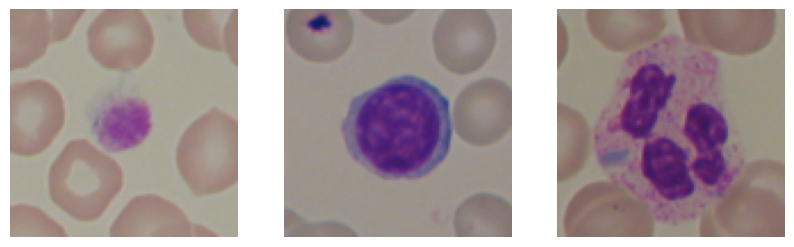

Class: 1


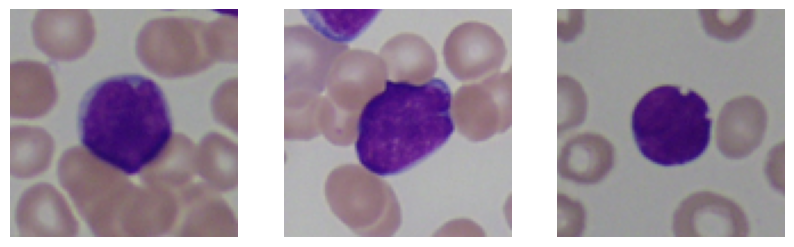

In [4]:
# Define the figure size and number of images per row
fig_size = (10, 3)
num_images_per_row = 3

# Group the DataFrame by class label
grouped = df.groupby('label')

# Iterate over the groups and display the images
for label, group_indices in grouped.groups.items():
    print('Class:', label)
    fig, axs = plt.subplots(1, num_images_per_row, figsize=fig_size)
    for i, index in enumerate(random.sample(list(group_indices), num_images_per_row)):
        image_path = df.loc[index, 'path']
        image = Image.open(image_path)
        image = image.resize((100, 100))  # Resize the image to 100 x 100
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

#### Splitting:
It is generally recommended to perform data augmentation on the training set after splitting it from the validation and testing sets. The reason for this is that data augmentation is a technique used to artificially increase the size of the training set by creating new examples from existing ones. This can help improve the performance of the model by exposing it to more diverse examples, and by reducing overfitting.
If we were to perform data augmentation on the entire dataset before splitting it into training, validation, and testing sets, we would be creating new examples that appear in multiple sets, which can lead to data leakage and overfitting. For example, if we flipp an image and added it to both the training and testing sets, the model may perform well on the testing set simply because it has seen the augmented version of the image before.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'label']], df[['label']], test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [6]:
# Print the number of samples in each set
print('Number of samples in training set:', X_train.shape[0])
print('Number of samples in validation set:', X_val.shape[0])
print('Number of samples in test set:', X_test.shape[0])

Number of samples in training set: 166
Number of samples in validation set: 42
Number of samples in test set: 52


#### Data augmentation:
 The data is generated dynamically, or "on the fly", during the training process. This is in contrast to preloading the entire dataset into memory before training, which can be memory-intensive and may not be feasible for large datasets. In the case of a data generator function, the data is generated in batches during each training epoch. The function yields a batch of data at a time, and the model trains on that batch before requesting the next batch from the generator. This allows for efficient use of memory and enables training on larger datasets.

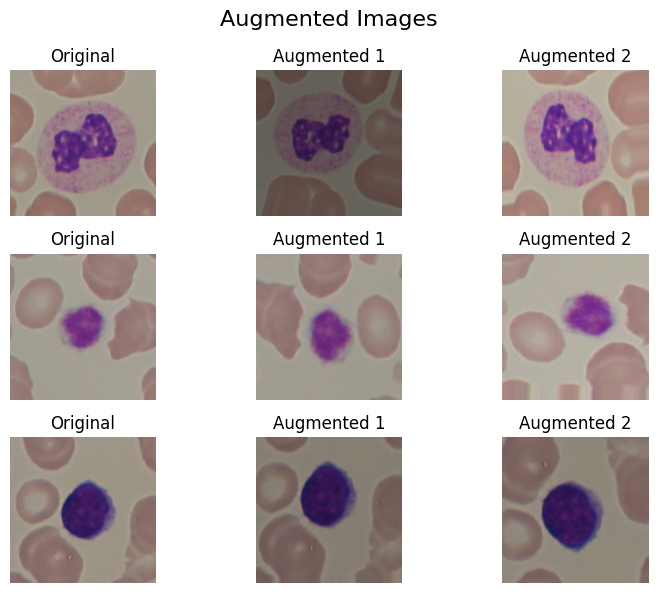

In [7]:
def func_TV_dGen(dataframe, input_shape, preprocess):

  # Define the parameters for data augmentation
  datagen= ImageDataGenerator(
      rotation_range=20,  # random rotation between 0 and 20 degrees
      width_shift_range=0.1,  # random horizontal shift of up to 10% of the width
      height_shift_range=0.1,  # random vertical shift of up to 10% of the height
      shear_range=0.2,  # random shearing between -20 and 20 degrees
      zoom_range=0.2,  # random zoom between 80% and 120%
      horizontal_flip=True,  # random horizontal flipping
      vertical_flip=True,  # random vertical flipping
      brightness_range=[0.5, 1.5],  # random brightness adjustment
      preprocessing_function=preprocess# histogram equalization
  )
  return datagen.flow_from_dataframe(dataframe=dataframe, x_col='path', y_col='label', target_size=input_shape, batch_size=32, class_mode='categorical', shuffle=True)

def augmented_images(image_paths, data_generator):
    """
    Display original images and their augmented versions generated by a data generator.

    Parameters:
    -----------
    image_paths : list
        A list of file paths for the original images.
    data_generator : keras.preprocessing.image.ImageDataGenerator
        A data generator used to augment the images.

    Returns:
    --------
    None
    """
    fig, axs = plt.subplots(nrows=len(image_paths), ncols=3, figsize=(8, 2*len(image_paths)), sharey=True)
    fig.suptitle('Augmented Images', fontsize=16)

    for row, path in enumerate(image_paths):
        original_image = Image.open(path).resize((200, 200))
        axs[row, 0].imshow(original_image)
        axs[row, 0].axis('off')
        axs[row, 0].set_title('Original')

        iterator = data_generator.flow(np.expand_dims(original_image, 0), batch_size=1)

        for col in range(1, 3):
            augmented_image = iterator.next()[0].astype('uint8')
            axs[row, col].imshow(augmented_image)
            axs[row, col].axis('off')
            axs[row, col].set_title(f'Augmented {col}')

    plt.tight_layout()
    plt.show()


datagen= ImageDataGenerator(
      rotation_range=20,  # random rotation between 0 and 20 degrees
      width_shift_range=0.1,  # random horizontal shift of up to 10% of the width
      height_shift_range=0.1,  # random vertical shift of up to 10% of the height
      shear_range=0.2,  # random shearing between -20 and 20 degrees
      zoom_range=0.2,  # random zoom between 80% and 120%
      horizontal_flip=True,  # random horizontal flipping
      vertical_flip=True,  # random vertical flipping
      brightness_range=[0.5, 1.5]  # random brightness adjustment
      # preprocessing_function=lambda x: cv2.equalizeHist(x)  # histogram equalization
  )


augmented_images(np.random.choice(X_train['path'],3),datagen)

In [8]:
batch_size = 32

def generate_test_data(dataframe, input_shape, preprocess_func, rescale_factor=None):
    # Create an ImageDataGenerator object to preprocess the test data
    data_generator = ImageDataGenerator(preprocessing_function=preprocess_func, rescale=rescale_factor)
    batch_size = sorted([int(len(dataframe) / n) for n in range(1, len(dataframe)+1) if len(dataframe) % n == 0 and len(dataframe)/n <= 80], reverse=True)[0]

    # Create a generator object using the ImageDataGenerator and DataFrame
    data_generator_obj = data_generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='path',
        y_col='label',
        target_size=input_shape,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size
    )

    return data_generator_obj


length=len(X_test)
test_steps=int(length/batch_size)

#### Performace measure:
 performance takes in a test data generator, the number of steps for the generator, and a trained model as input. The function then evaluates the model's performance on the test data and prints various performance metrics, including accuracy, precision, recall, specificity, and the confusion matrix for each class.

In [9]:
def performance(test_generator, test_steps, model):
    predictions = []
    true_labels = test_generator.labels

    classes = list(test_generator.class_indices.keys())
    pred_probs = model.predict(test_generator, verbose=1)
    predictions = np.argmax(pred_probs, axis=-1)

    accuracy = accuracy_score(true_labels, predictions)
    print("accuracy: ", accuracy)
    precision = precision_score(true_labels, predictions, average='weighted')
    print("precision: ", precision)
    recall = recall_score(true_labels, predictions, average='weighted')
    print("recall: ", recall)
    cm = multilabel_confusion_matrix(true_labels, predictions)

    # extract true positives, true negatives, false positives, and false negatives
    tp = cm[:, 1, 1]
    tn = cm[:, 0, 0]
    fp = cm[:, 0, 1]
    fn = cm[:, 1, 0]

    # compute specificity per class
    with np.errstate(divide='ignore', invalid='ignore'):
        specificity = tn / (tn + fp)
    specificity[np.isnan(specificity)] = 0
    print("specificity: ", specificity)


    for i, c in enumerate(classes):
        plt.figure(figsize=(3, 2))
        sns.heatmap(cm[i], annot=True, vmin=0, fmt='g', cmap='cividis', cbar=False)
        plt.xticks(np.arange(2)+.5, ['True', 'False'], rotation=90)
        plt.yticks(np.arange(2)+.5, ['Positive', 'Negative'], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for Class {c}")
        plt.show()

    print(classification_report(true_labels, predictions, target_names=classes, digits= 4))


    return accuracy, precision, recall, specificity

#### Training the model in the homework:

In [10]:
# Define the CNN model
model = tf.keras.Sequential()

# Add Convolutional layers
model.add(layers.Conv2D(48, (3, 3), strides=2, activation='relu', padding='same', input_shape=(257, 257, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(48, (3, 3), strides=1, activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(48, (5, 5), strides=1, activation='relu', padding='same'))

model.add(layers.Conv2D(48, (3, 3), strides=1, activation='relu', padding='same'))

model.add(layers.Conv2D(48, (3, 3), strides=1, activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 129, 129, 48)      1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 48)        20784     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 48)        57648     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 48)        2

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
acc = []

In [12]:
# Train the model
preprocess = None
input_shape = (257, 257)
epoch = 500

# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2,
                    patience=10, baseline=None, restore_best_weights=True)

history = model.fit(func_TV_dGen(X_train, input_shape, preprocess),
                    validation_data=func_TV_dGen(X_val, input_shape, preprocess),
                    steps_per_epoch=4,
                    epochs=epoch,
                    verbose=2,
                    batch_size=100,
                    callbacks=[es])

best_acc = max(history.history['val_accuracy'])*100
acc.append(best_acc)

Found 166 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Epoch 1/500
4/4 - 17s - loss: 9.7216 - accuracy: 0.5588 - val_loss: 7.6681 - val_accuracy: 0.4524 - 17s/epoch - 4s/step
Epoch 2/500
4/4 - 6s - loss: 6.4671 - accuracy: 0.4688 - val_loss: 2.0504 - val_accuracy: 0.5476 - 6s/epoch - 1s/step
Epoch 3/500
4/4 - 4s - loss: 2.4643 - accuracy: 0.5490 - val_loss: 0.8159 - val_accuracy: 0.6905 - 4s/epoch - 913ms/step
Epoch 4/500
4/4 - 3s - loss: 1.5911 - accuracy: 0.6078 - val_loss: 1.1438 - val_accuracy: 0.4524 - 3s/epoch - 862ms/step
Epoch 5/500
4/4 - 8s - loss: 1.6980 - accuracy: 0.5625 - val_loss: 0.6867 - val_accuracy: 0.6429 - 8s/epoch - 2s/step
Epoch 6/500
4/4 - 3s - loss: 1.2308 - accuracy: 0.6078 - val_loss: 0.8923 - val_accuracy: 0.5476 - 3s/epoch - 825ms/step
Epoch 7/500
4/4 - 3s - loss: 0.9975 - accuracy: 0.6078 - val_loss: 0.4647 - val_accuracy: 0.8095 - 3s/epoch - 819ms/step
Epoch 8/500
4/4 - 5s - loss: 0.8234 - acc

In [13]:
print("Best:", round(best_acc, 4), "%")

Best: 95.2381 %


##### Displaying variation of each epoch in training accuracy and loss function:

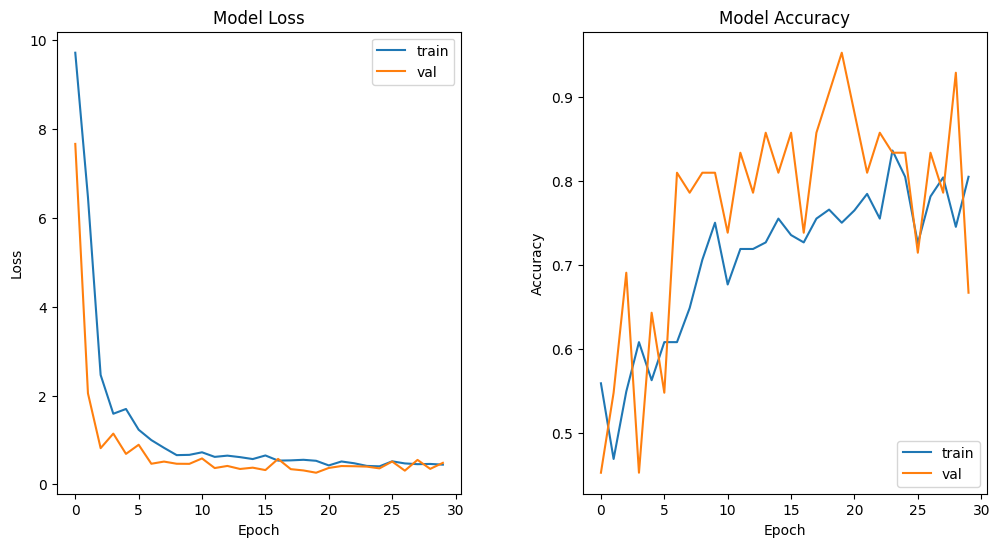

In [14]:
import matplotlib.pyplot as plt

# create figure with a single row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot training and validation loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='upper right')

# plot training and validation accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='lower right')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# show the plot
plt.show()

##### Displaying model performance metrics:

Found 52 validated image filenames belonging to 2 classes.
1/1 [==============================] - 1s 816ms/step
accuracy:  0.8461538461538461
precision:  0.8473193473193473
recall:  0.8461538461538461
specificity:  [0.89285714 0.79166667]


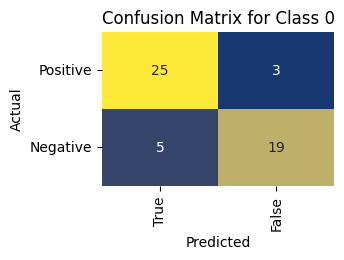

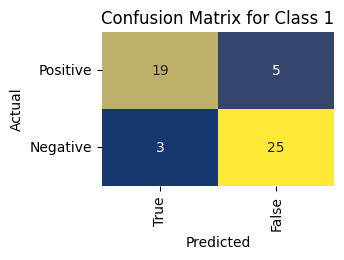

              precision    recall  f1-score   support

           0     0.8636    0.7917    0.8261        24
           1     0.8333    0.8929    0.8621        28

    accuracy                         0.8462        52
   macro avg     0.8485    0.8423    0.8441        52
weighted avg     0.8473    0.8462    0.8455        52



In [15]:
accuracy, precision, recall, specificity = performance(generate_test_data(X_test, (257, 257), preprocess), test_steps, model)

#### New architecture #1:
In this updated architecture, we're using larger filter sizes in some of the convolutional layers and adding batch normalization layers after each convolutional layer. We're also increasing the number of filters in the convolutional layers and adding more convolutional layers to the model. Finally, we're using a larger fully connected layer and adding batch normalization and a dropout layer to prevent overfitting.

In [23]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same', input_shape=(257, 257, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(256, (5, 5), strides=1, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (5, 5), strides=1, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 129, 129, 64)      1792      
                                                                 
 batch_normalization_7 (Batc  (None, 129, 129, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, 65, 65, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 65, 65, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
acc = []
# Train the model
preprocess = None
input_shape = (257, 257)
epoch = 500

# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2,
                    patience=10, baseline=None, restore_best_weights=True)

history = model.fit(func_TV_dGen(X_train, input_shape, preprocess),
                    validation_data=func_TV_dGen(X_val, input_shape, preprocess),
                    steps_per_epoch=4,
                    epochs=epoch,
                    verbose=1,
                    batch_size=100,
                    callbacks=[es])

best_acc = max(history.history['val_accuracy'])*100
acc.append(best_acc)

In [27]:
print("Best:", round(best_acc, 4), "%")

Best: 69.0476 %


##### Displaying model performances metrics:


Found 52 validated image filenames belonging to 2 classes.
1/1 [==============================] - 0s 234ms/step
accuracy:  0.5576923076923077
precision:  0.6974358974358974
recall:  0.5576923076923077
specificity:  [0.21428571 0.95833333]


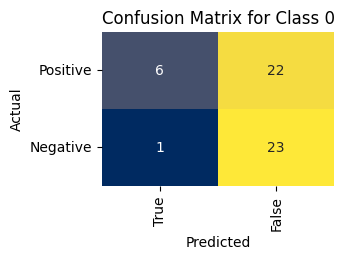

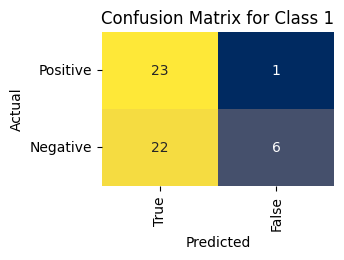

              precision    recall  f1-score   support

           0     0.5111    0.9583    0.6667        24
           1     0.8571    0.2143    0.3429        28

    accuracy                         0.5577        52
   macro avg     0.6841    0.5863    0.5048        52
weighted avg     0.6974    0.5577    0.4923        52



In [28]:
accuracy, precision, recall, specificity = performance(generate_test_data(X_test, (257, 257), preprocess), test_steps, model)

#### Resnet50:
ResNet-50 is a 50-layer deep neural network that uses residual connections to skip over some layers, allowing the network to learn more easily. The residual connections allow the network to learn the identity mapping, which helps to improve gradient flow and hence training performance. The network also uses batch normalization and ReLU activation functions to improve the training of deep neural networks.

In [ ]:
# Load the ResNet50 model pre-trained on ImageNet
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(257, 257, 3))

# Freeze all layers in the pre-trained model
for layer in resnet.layers:
    layer.trainable = False

# Add a custom classification head
x = Flatten()(resnet.output)
x = Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Create a new model with the custom classification head
model = Model(inputs=resnet.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
preprocess = preprocess_input
input_shape = (257, 257)
epoch = 500

# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2,
                    patience=10, baseline=None, restore_best_weights=True)

history = model.fit(func_TV_dGen(X_train, input_shape, preprocess),
                    validation_data=func_TV_dGen(X_val, input_shape, preprocess),
                    steps_per_epoch=4,
                    epochs=epoch,
                    verbose=1,
                    batch_size=100,
                    callbacks=[es])

best_acc = max(history.history['val_accuracy'])*100
acc.append(best_acc)

In [21]:
print("Best:", round(best_acc, 4), "%")

Best: 97.619 %


##### Displaying model performances metrics:

Found 52 validated image filenames belonging to 2 classes.
1/1 [==============================] - 4s 4s/step
accuracy:  0.9423076923076923
precision:  0.9478908188585607
recall:  0.9423076923076923
specificity:  [1.    0.875]


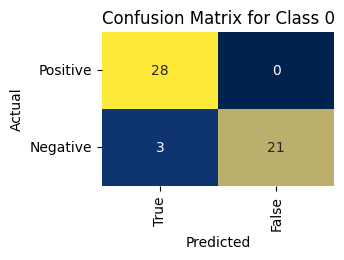

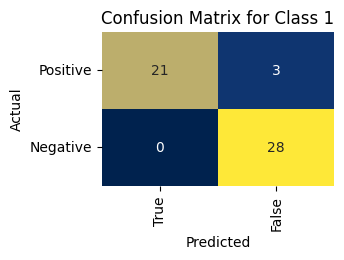

              precision    recall  f1-score   support

           0     1.0000    0.8750    0.9333        24
           1     0.9032    1.0000    0.9492        28

    accuracy                         0.9423        52
   macro avg     0.9516    0.9375    0.9412        52
weighted avg     0.9479    0.9423    0.9419        52



In [22]:
accuracy, precision, recall, specificity = performance(generate_test_data(X_test, (257, 257), preprocess), test_steps, model)

#### Final results:

|       | Train accuracy | Test Accuracy |
| ----------- | ----------- | --------------|
| Homework model      |   97      | 94 |
| Architecture #1   | 69        | 55 |
| Resnet50  | 97        | 94|

As it is obvious, Resnet50 and the given model have nearly the same performance and architecture #1 does not have a good performace in compared to the two other model.